In [1]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
import tqdm

In [2]:
def get_data(filepath):
    data = {}
    for dir in glob.glob(filepath):
        images = []
        for file in glob.glob(dir+'/color_*.png'):
            images.append(file)
        data.setdefault(dir[-1],images)
    return data

In [3]:
dataset = os.path.abspath('dataset5/*/*')
data = get_data(dataset)

In [4]:
def preprocess_images(dict,height=64,width= 64):
    images = []
    labels = []
    
    for k,v in dict.items():
        for file in v:
            img = cv2.imread(file)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(height,width))
            img = img/255.00
            images.append(img)
            labels.append(k)
            
    return (np.array(images),np.array(labels).reshape(-1,1))

In [5]:
images, labels = preprocess_images(data)

In [6]:
from sklearn.preprocessing import LabelBinarizer

lbl_bin = LabelBinarizer()
labels = lbl_bin.fit_transform(labels)

In [7]:
from sklearn.model_selection import train_test_split

X_train , X_test, Y_train, Y_test = train_test_split(images,labels,test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.25,random_state=1)

In [8]:
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

classifier = Sequential()
classifier.add(Convolution2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Convolution2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(activation = 'relu', units=256))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'sigmoid', units=24))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

classifier.summary()

Using TensorFlow backend.
W0816 16:55:04.361936 11836 deprecation_wrapper.py:119] From C:\Users\hp\.conda\envs\tensor_test\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 16:55:04.388303 11836 deprecation_wrapper.py:119] From C:\Users\hp\.conda\envs\tensor_test\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 16:55:04.391295 11836 deprecation_wrapper.py:119] From C:\Users\hp\.conda\envs\tensor_test\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 16:55:04.410244 11836 deprecation_wrapper.py:119] From C:\Users\hp\.conda\envs\tensor_test\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0816 16:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
__________

In [9]:
classifier.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
epochs = 10
models_dir = 'saved_models'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath=f'{models_dir}/best_weights.hdf5',verbose=1,save_best_only=True)
es_callback = EarlyStopping(monitor='val_loss')



In [11]:
history = classifier.fit(X_train,Y_train, validation_data=(X_val,Y_val),callbacks=[checkpointer,es_callback],epochs=epochs,verbose=1)

W0816 16:55:15.029028 11836 deprecation.py:323] From C:\Users\hp\.conda\envs\tensor_test\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7527 samples, validate on 2510 samples
Epoch 1/10
7527/7527 [==============================] - ETA: 8:03 - loss: 3.5903 - acc: 0.0000e+0 - ETA: 4:06 - loss: 3.1985 - acc: 0.1250    - ETA: 2:07 - loss: 2.9235 - acc: 0.265 - ETA: 1:44 - loss: 2.8504 - acc: 0.300 - ETA: 1:16 - loss: 2.7431 - acc: 0.361 - ETA: 1:08 - loss: 2.7073 - acc: 0.382 - ETA: 1:01 - loss: 2.6899 - acc: 0.402 - ETA: 51s - loss: 2.6479 - acc: 0.420 - ETA: 48s - loss: 2.6263 - acc: 0.42 - ETA: 45s - loss: 2.6054 - acc: 0.43 - ETA: 40s - loss: 2.5744 - acc: 0.46 - ETA: 38s - loss: 2.5603 - acc: 0.47 - ETA: 36s - loss: 2.5484 - acc: 0.48 - ETA: 33s - loss: 2.5290 - acc: 0.49 - ETA: 32s - loss: 2.5238 - acc: 0.49 - ETA: 29s - loss: 2.5088 - acc: 0.50 - ETA: 29s - loss: 2.5032 - acc: 0.50 - ETA: 28s - loss: 2.4951 - acc: 0.51 - ETA: 27s - loss: 2.4869 - acc: 0.52 - ETA: 26s - loss: 2.4807 - acc: 0.53 - ETA: 25s - loss: 2.4767 - acc: 0.53 - ETA: 25s - loss: 2.4688 - acc: 0.54 - ETA: 23s - loss: 2.4550 - acc: 0.55 -

7527/7527 [==============================] - ETA: 12s - loss: 0.6080 - acc: 0.87 - ETA: 10s - loss: 0.5528 - acc: 0.89 - ETA: 11s - loss: 0.6120 - acc: 0.87 - ETA: 11s - loss: 0.5784 - acc: 0.88 - ETA: 11s - loss: 0.5546 - acc: 0.88 - ETA: 10s - loss: 0.5492 - acc: 0.88 - ETA: 10s - loss: 0.5378 - acc: 0.88 - ETA: 10s - loss: 0.5267 - acc: 0.89 - ETA: 10s - loss: 0.5170 - acc: 0.89 - ETA: 10s - loss: 0.5087 - acc: 0.89 - ETA: 10s - loss: 0.5004 - acc: 0.89 - ETA: 10s - loss: 0.4898 - acc: 0.90 - ETA: 10s - loss: 0.4799 - acc: 0.90 - ETA: 10s - loss: 0.4856 - acc: 0.90 - ETA: 10s - loss: 0.4788 - acc: 0.90 - ETA: 10s - loss: 0.4716 - acc: 0.90 - ETA: 10s - loss: 0.4775 - acc: 0.90 - ETA: 10s - loss: 0.4919 - acc: 0.90 - ETA: 10s - loss: 0.4929 - acc: 0.90 - ETA: 10s - loss: 0.4811 - acc: 0.90 - ETA: 10s - loss: 0.4788 - acc: 0.90 - ETA: 10s - loss: 0.4764 - acc: 0.91 - ETA: 9s - loss: 0.4681 - acc: 0.9110 - ETA: 9s - loss: 0.4652 - acc: 0.910 - ETA: 9s - loss: 0.4645 - acc: 0.909 - ETA:

7527/7527 [==============================] - ETA: 13s - loss: 0.0457 - acc: 1.00 - ETA: 10s - loss: 0.1312 - acc: 0.98 - ETA: 11s - loss: 0.1341 - acc: 0.98 - ETA: 11s - loss: 0.1183 - acc: 0.98 - ETA: 11s - loss: 0.1207 - acc: 0.98 - ETA: 11s - loss: 0.1421 - acc: 0.98 - ETA: 10s - loss: 0.1304 - acc: 0.98 - ETA: 10s - loss: 0.1282 - acc: 0.98 - ETA: 10s - loss: 0.1222 - acc: 0.98 - ETA: 10s - loss: 0.1162 - acc: 0.98 - ETA: 10s - loss: 0.1075 - acc: 0.98 - ETA: 10s - loss: 0.1049 - acc: 0.98 - ETA: 10s - loss: 0.1052 - acc: 0.98 - ETA: 10s - loss: 0.1051 - acc: 0.98 - ETA: 10s - loss: 0.1010 - acc: 0.98 - ETA: 10s - loss: 0.1022 - acc: 0.98 - ETA: 9s - loss: 0.0976 - acc: 0.9888 - ETA: 9s - loss: 0.0933 - acc: 0.989 - ETA: 9s - loss: 0.0897 - acc: 0.989 - ETA: 9s - loss: 0.0884 - acc: 0.989 - ETA: 9s - loss: 0.0865 - acc: 0.988 - ETA: 9s - loss: 0.0828 - acc: 0.989 - ETA: 9s - loss: 0.0822 - acc: 0.989 - ETA: 9s - loss: 0.0791 - acc: 0.989 - ETA: 9s - loss: 0.0764 - acc: 0.990 - ETA:

In [12]:
history.history

{'val_loss': [0.578847622301474, 0.1642121129064446, 0.2196735077882668],
 'val_acc': [0.8533864542782544, 0.9645418326693227, 0.9386454183741869],
 'loss': [1.3528858080191553, 0.3020210334650308, 0.03522160464792086],
 'acc': [0.7441211638102829, 0.9399495150790488, 0.9949515079048757]}

In [13]:
classifier.load_weights(os.path.join(models_dir,'best_weights.hdf5'))

In [14]:
classifier.evaluate(X_test,Y_test)

2510/2510 [==============================] - ETA: 2: - ETA: 34s - ETA: 19 - ETA: 13 - ETA: 10 - ETA: 7 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 1ms/step


[0.13988376530518096, 0.9685258962718614]

In [37]:
cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    cv2.imshow("test", frame)
    if not ret:
        break
    k = cv2.waitKey(1)

    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

opencv_frame_0.png written!
opencv_frame_1.png written!
opencv_frame_2.png written!
Escape hit, closing...


In [50]:
img_test = cv2.imread('color_17_0015.png')
img_test = cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test,(64,64))
img_test = img_test/255.00

In [51]:
img_test_shape = img_test.reshape(1,64,64,3)

Text(0.5, 1.0, "pred: ['r']")

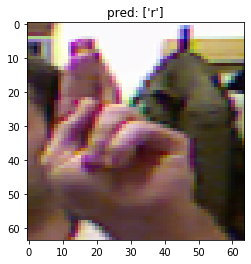

In [52]:
import matplotlib.pyplot as plt

custom_preds = classifier.predict(img_test_shape)
plt.imshow(img_test)
plt.title('pred: {}'.format(lbl_bin.classes_[np.argmax(custom_preds, axis = -1)]))